# E6. Kaggle Competition : House Price Prediction(2019)
## 1. 데이터 준비 및 전처리 작업

In [9]:
# 필요한 라이브러리 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 그래프 구현
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [10]:
# 파일경로 설정
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [11]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [12]:
# date 정수형 데이터 처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [13]:
# price 컬럼 제거
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [14]:
# id 컬럽 제거
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
# test 데이터 전처리 작업
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


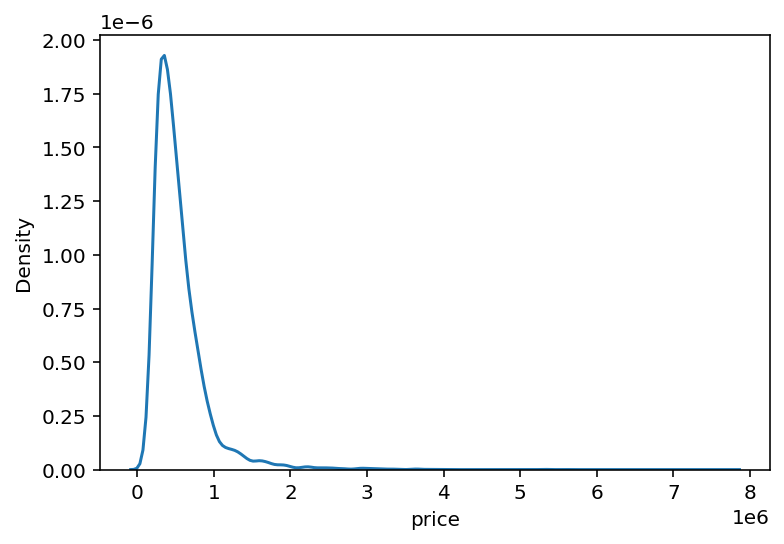

In [16]:
# 가격 데이터 분포도 확인
sns.kdeplot(y)
plt.show()

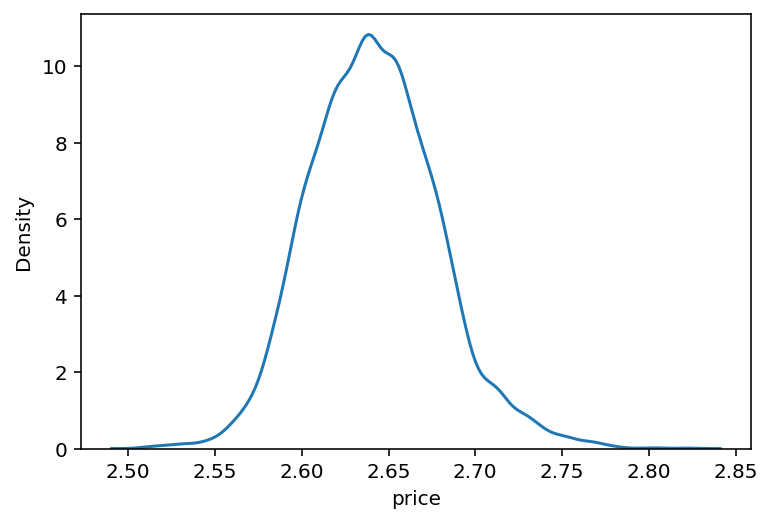

In [18]:
# 로그변환을 통한 정규분포화
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [20]:
# 훈련 데이터 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 2. 모델 튜닝

In [33]:
# 각종 라이브러리 호출
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 함수 적용(RMSE)
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))) # 원래 데이터에 맞게 계산

# 함수 적용(모델별 RMSE 값 확인)
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
    
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
    
        # data frame 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

# 랜덤시드 값 고정
random_state=2020 # None 초기값

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [31]:
# 모델별 RMSE 값 확인
get_scores(models, train, y)
df

{'GradientBoostingRegressor': 0.1809232218184817,
 'XGBRegressor': 0.16679809240874063,
 'LGBMRegressor': 0.16314856105233844,
 'RandomForestRegressor': 0.1772598365624751}

In [34]:
# 하이퍼 파라미터(그리드 탐색) GridSearchCV 
'''
param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
scoring : 모델의 성능을 평가할 지표
cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수
'''

#xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

# LightGBM(lgbm)
model = LGBMRegressor(random_state=random_state)

# GridSearchCV
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    2.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [40]:
# GridSearchCV 결과 확인
grid_model.cv_results_

{'mean_fit_time': array([0.09591112, 0.12985516, 0.25003648, 0.39455237]),
 'std_fit_time': array([0.00307653, 0.00847526, 0.01030173, 0.01920698]),
 'mean_score_time': array([0.00567303, 0.01321754, 0.0147028 , 0.03189669]),
 'std_score_time': array([0.00021496, 0.01016018, 0.00097837, 0.01150568]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.00037839, -0.00027917, -0.00014791, -0.00013679]),
 'split1_test_score': array([-0.00038423, -0.00029197, -0.00015652, -0.00014476]),
 'split2_test_score': array([-0.00037037

In [39]:
# 결과 값 정제 1 - 파라미터 조합
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [37]:
# 결과 값 정제 2 - 테스트 점수
score = grid_model.cv_results_['mean_test_score']
score

array([-0.00036765, -0.00027737, -0.00015077, -0.00014011])

In [56]:
# 데이터 프레임 합치기
results = pd.DataFrame(params)
results['score'] = score
results

,max_depth,n_estimators,score
0,1,50,-0.000368
1,1,100,-0.000277
2,10,50,-0.000151
3,10,100,-0.000140


In [57]:
# RMSE 점수 변환함수 적용(루트연산)
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.000368,0.019174
1,1,100,-0.000277,0.016655
2,10,50,-0.000151,0.012279
3,10,100,-0.000140,0.011837


In [58]:
# log를 취한 값에서 RMSE를 구한 RMSLE 값
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.000368,0.019174
1,1,100,-0.000277,0.016655
2,10,50,-0.000151,0.012279
3,10,100,-0.000140,0.011837


In [64]:
# RMSLE 열 오름차순 정렬
results.sort_values(by=['RMSLE'], axis=0) # or results = results.sort_values('RMSLE')

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000140,0.011837
2,10,50,-0.000151,0.012279
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019174


In [68]:
# 하이퍼 파라미터(그리드 탐색) GridSearchCV 함수
'''
param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
scoring : 모델의 성능을 평가할 지표
cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수
'''
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 피팅
    grid_model.fit(train, y)
    
    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results.sort_values(by=['RMSLE'], axis=0) # or results = results.sort_values('RMSLE')

In [69]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    2.1s finished


In [71]:
# 모델 적용
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

# 변환함수 적용
prediction = np.expm1(prediction)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.06434146, 13.01526921, 14.14968879, ..., 13.03196719,
       12.67778315, 12.95343288])

In [72]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [73]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,13.064341
1,15036,13.015269
2,15037,14.149689
3,15038,12.673338
4,15039,12.704526


In [74]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [78]:
# 함수 구현(모델 구현 및 저장)
def save_submission(model, train, y, test, model_name, rmsle=None):
    # 모델 학습 및 예측
    model.fit(train, y)
    prediction = model.predict(test)
    
    # 변환함수 적용
    prediction = np.expm1(prediction)
    
    # 데이터 프레임 불러들이기
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # 데이터 프레임 편집
    submission['price'] = prediction
    
    # 파일저장
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    
    print('{} saved!'.format(submission_csv_path))

In [79]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!
